# Setup

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

# Loading Dataset

In [3]:
!unzip data.zip

Archive:  data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/.DS_Store          
replace __MACOSX/data/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/data/._.DS_Store  
replace data/imagenet/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
with open("data/imagenet_labels.txt") as file:
    classes = eval(file.read())

In [5]:
for i in enumerate(classes.items()):
    print(i[1][1])

tench, Tinca tinca
goldfish, Carassius auratus
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
tiger shark, Galeocerdo cuvieri
hammerhead, hammerhead shark
electric ray, crampfish, numbfish, torpedo
stingray
cock
hen
ostrich, Struthio camelus
brambling, Fringilla montifringilla
goldfinch, Carduelis carduelis
house finch, linnet, Carpodacus mexicanus
junco, snowbird
indigo bunting, indigo finch, indigo bird, Passerina cyanea
robin, American robin, Turdus migratorius
bulbul
jay
magpie
chickadee
water ouzel, dipper
kite
bald eagle, American eagle, Haliaeetus leucocephalus
vulture
great grey owl, great gray owl, Strix nebulosa
European fire salamander, Salamandra salamandra
common newt, Triturus vulgaris
eft
spotted salamander, Ambystoma maculatum
axolotl, mud puppy, Ambystoma mexicanum
bullfrog, Rana catesbeiana
tree frog, tree-frog
tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
loggerhead, loggerhead turtle, Caretta caretta
leatherback

In [0]:
transform = transforms.Compose([
                                transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
])

In [0]:
evalset = torchvision.datasets.ImageFolder(root='./data/imagenet', transform=transform)

In [0]:
batch_size = 1

In [0]:
evalloader = torch.utils.data.DataLoader(evalset, shuffle=True, batch_size=batch_size)

In [0]:
dataiter = iter(evalloader)

In [11]:
images, labels = dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
0


# Loading VGG16 pretrained

In [0]:
vgg = models.vgg16_bn(pretrained=True)

In [13]:
vgg.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Visualise Image

In [0]:
def imshow(img, title):
    std_correction = np.asarray([0.229, 0.2224, 0.225]).reshape(3,1,1)
    mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3,1,1)
    npimg = np.multiply(img.numpy(), std_correction) + mean_correction
    npimg = np.transpose(npimg, (1,2,0))

    plt.figure(figsize=(batch_size*4, 4))
    plt.axis('off')
    plt.imshow(npimg)
    plt.title(title)
    plt.show()

In [0]:
def show_batch_images(dataloader):
    images, _ = next(iter(dataloader))
    outputs = vgg(images)
    _, pred = torch.max(outputs.data, 1)

    img = torchvision.utils.make_grid(images)
    imshow(img=img, title=[classes[x.item()] for x in pred])

    return images, pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


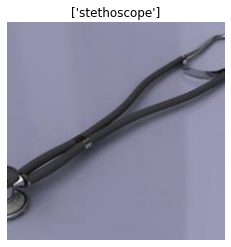

In [16]:
images, pred = show_batch_images(evalloader)

# Occlusion Analysis

In [17]:
outputs = vgg(images)
print(outputs.shape)
outputs = nn.functional.softmax(outputs, dim=1)
prob_no_occ, pred = torch.max(outputs.data, 1)
prob_no_occ = prob_no_occ[0].item()
print(prob_no_occ)

torch.Size([1, 1000])
0.9811913371086121


In [0]:
def occlusion(model, image, label, occ_size=50, occ_stride=50, occ_pixel=0.5):

    width, height = image.shape[-2], image.shape[-1]

    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))

    heatmap = torch.zeros((output_height, output_width))

    for h in range(0, height):
        for w in range(0, width):

            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)

            if (w_end) >= width or (h_end) >= height:
                continue

            input_image = image.clone().detach()
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel

            output = vgg(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]

            heatmap[h,w] = prob
    
    return heatmap

In [0]:
heatmap = occlusion(vgg, images, pred[0].item(), 32, 14)

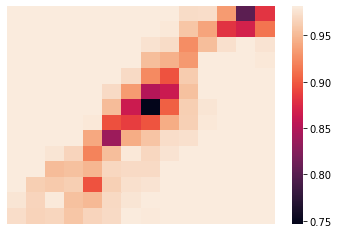

In [20]:
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)

# Filter Visualisation

In [0]:
alexnet = models.alexnet(pretrained=True)

In [22]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
def plot_filters_single_channel_big(t):
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]

    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0,2,1,3))
    npimg = npimg.ravel().reshape(nrows, ncols)

    npimg = npimg.T

    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='Greys', ax=ax, cbar=False)

In [0]:
def plot_filters_single_channel(t):

    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    nrows = 1 + nplots//ncols

    npimg = np.array(t.numpy(), np.float32)

    count = 0

    fig = plt.figure(figsize=(ncols, nrows))
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i,j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg))/np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i)+ ',' + str(j))
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.axis('off')
    
    plt.tight_layout()
    plt.show()

In [0]:
def plot_filters_multi_channel(t):

    num_kernels = t.shape[0]

    num_cols = 12
    num_rows = num_kernels

    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows, num_cols, i+1)

        npimg = np.array(t[i].numpy(), np.float32)
        npimg = (npimg - np.mean(npimg))/np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1,2,0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.tight_layout()
    plt.show()

In [0]:
def plot_weights(model, layer_num, single_channel=True, collated=False):

    layer = model.features[layer_num]
    if isinstance(layer, nn.Conv2d):
        weight_tensor = model.features[layer_num].weight.data
        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor)
            else:
                plot_filters_single_channel(weight_tensor)
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                print('Can only plot weights having 3 channels')
    else:
        print('Can only visualise layers which are convolutional')

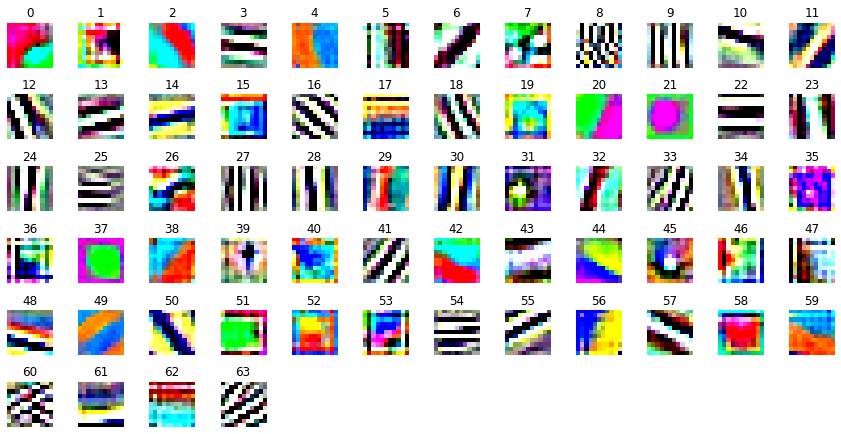

In [27]:
plot_weights(alexnet, 0, single_channel=False)

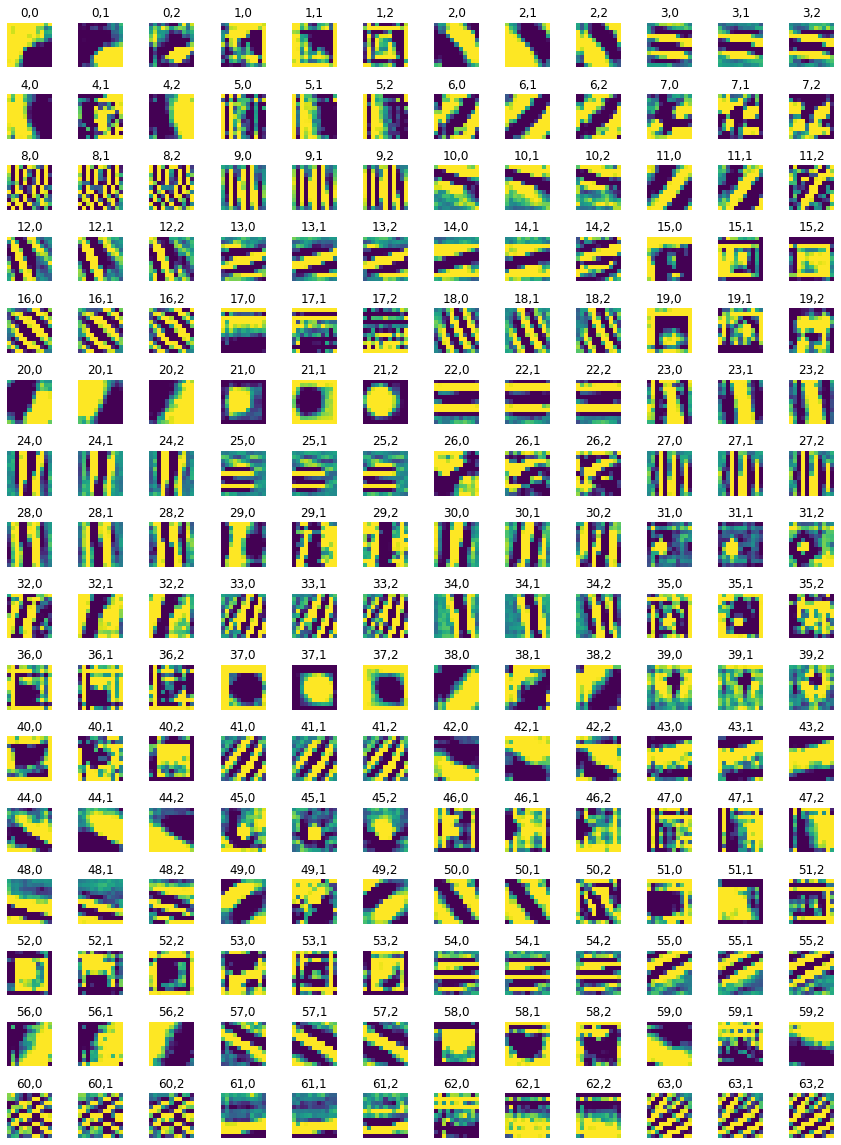

In [28]:
plot_weights(alexnet, 0, single_channel=True)

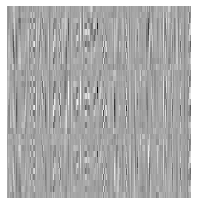

In [29]:
plot_weights(alexnet, 0, single_channel=True, collated=True)

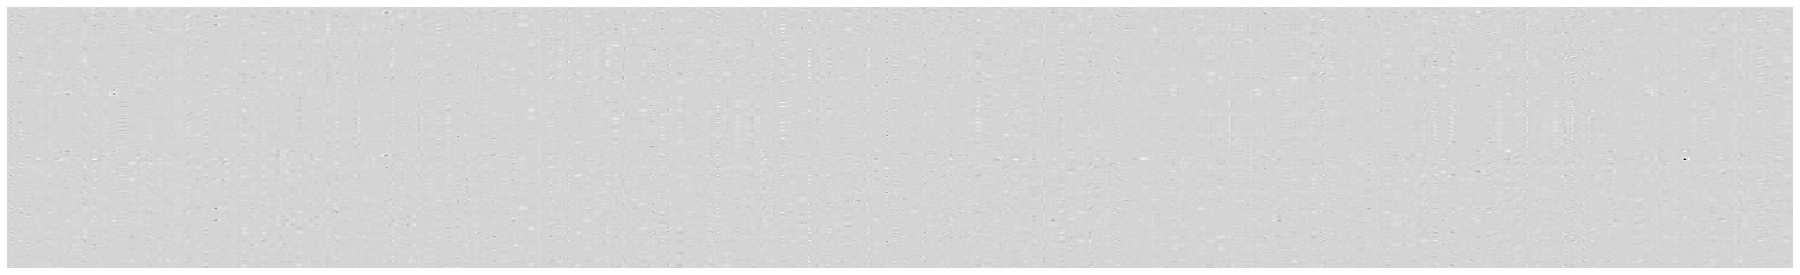

In [30]:
plot_weights(alexnet, 3, single_channel=True, collated=True)

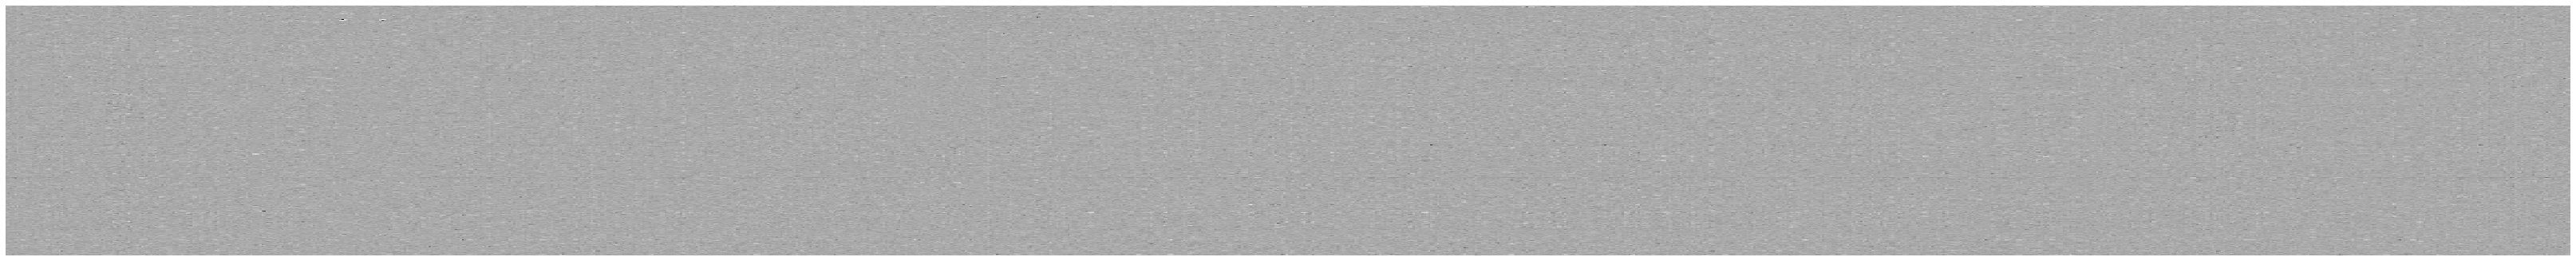

In [31]:
plot_weights(alexnet, 6, single_channel=True, collated=True)

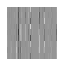

In [32]:
plot_weights(vgg, 0, single_channel=True, collated=True)

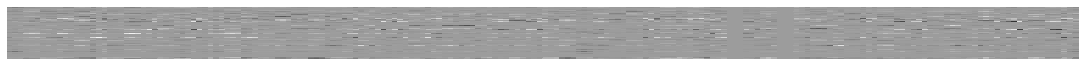

In [33]:
plot_weights(vgg, 3, single_channel=True, collated=True)

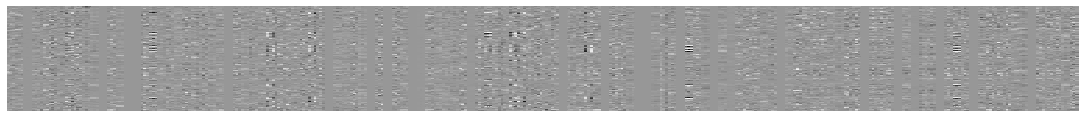

In [34]:
plot_weights(vgg, 7, single_channel=True, collated=True)